In [1]:
# AUDIO_DIR = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/Kaggle/"
SAMPLE_RATE = 22050 # sample rate of the audio file
bit_depth = 16 # bit depth of the audio file
hop_length = 512
n_mfcc =  20 # number of MFCCs features
n_fft=1024, # window size
n_mels = 256 # number of mel bands to generate
win_length = None # window length


# Training parameters
batch_size = 128
learning_rate = 0.001
num_epochs = 20




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef,confusion_matrix
import torchaudio
import numpy as np



from cnn_model import CNNModel
from datapreprocessing import AudioProcessor


The test passed successfully.


In [3]:
# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():  # if you have apple silicon mac
    device = "mps"  # if it doesn't work try device = torch.device('mps')
else:
    device = "cpu"
print(f"Using {device}")

Using mps


In [4]:



path_to_train = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/train/"
path_to_test = "/Users/zainhazzouri/projects/Bachelor_Thesis/Data/test/"

train_dataset = AudioProcessor(audio_dir=path_to_train)
val_dataset = AudioProcessor(audio_dir=path_to_test)
# def custom_collate(batch):
# 
#     mfccs = []
#     labels = []
#     
#     for mfcc, label in batch:
#         mfccs.append(mfcc)
#         labels.append(label)
#         print(batch[0])
# 
#     return torch.stack(mfccs), torch.tensor(labels)



# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Initialize model, loss, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [5]:
def calculate_sdr(target, prediction):
    target = target.float()
    prediction = prediction.float()

    target_energy = torch.sum(target**2)
    error_signal = target - prediction
    error_energy = torch.sum(error_signal**2)

    sdr = 10 * torch.log10(target_energy / error_energy)
    return sdr


In [6]:
def one_hot_encode(labels, num_classes, device):
    return torch.eye(num_classes, device=device)[labels]


In [7]:
def evaluate(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    all_sdrs = []


    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = one_hot_encode(targets, num_classes=4, device=device).to(device)




            # Forward pass
            outputs = model(inputs)

            # Calculate SDR and append to list
            all_sdrs.append(calculate_sdr(targets, outputs))

            # Calculate loss
            loss = criterion(outputs, targets)

            # Update loss
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, targets = torch.max(targets, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store targets and predictions for metrics calculation
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_sdr = sum(all_sdrs) / len(all_sdrs)


    # Calculate average loss and accuracy
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate precision, recall, F1-score, and MCC
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    mcc = matthews_corrcoef(all_targets, all_predictions)

    return avg_loss, accuracy, precision, recall, f1_score, mcc, avg_sdr

    # Evaluate the model
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc, avg_sdr = evaluate(val_loader, model, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")
    print(f"Validation SDR: {avg_sdr:.4f}")

In [8]:
# Initialize lists for storing loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
val_mccs = []
val_sdrs = []


# training loop
for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        inputs = inputs.to(device)

        # targets = targets.to(device)
        targets = one_hot_encode(targets, num_classes=4, device=device).to(device)



        # Zero the parameter gradients
        optimizer.zero_grad() # zero the gradient buffers

        # Forward pass
        outputs = model(inputs)


        # print(f'outputs shape: {outputs.shape}')
        # print(f'targets shape: {targets.shape}')



        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Update loss
        running_loss += loss.item()

        # Update total and correct
        _, predicted = torch.max(outputs.data, 1)
        _, targets = torch.max(targets, 1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validate and store the validation loss and accuracy

    # Validate and store the validation metrics
    val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_mcc, val_sdr = evaluate(val_loader, model, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)
    val_mccs.append(val_mcc)
    val_sdrs.append(val_sdr)

    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1_score:.4f}")
    print(f"Validation MCC: {val_mcc:.4f}")

print("Training finished.")



Epoch: 1/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.71s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.3437 | Train Accuracy: 33.99%
Validation Loss: 1.2372 | Validation Accuracy: 49.44%
Validation Precision: 0.3392
Validation Recall: 0.4944
Validation F1-score: 0.3938
Validation MCC: 0.2156
Epoch: 2/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.49s/it]


Train Loss: 1.2520 | Train Accuracy: 48.03%
Validation Loss: 1.3007 | Validation Accuracy: 43.82%
Validation Precision: 0.4562
Validation Recall: 0.4382
Validation F1-score: 0.2812
Validation MCC: 0.0847
Epoch: 3/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.59s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1850 | Train Accuracy: 52.71%
Validation Loss: 1.4187 | Validation Accuracy: 32.58%
Validation Precision: 0.1991
Validation Recall: 0.3258
Validation F1-score: 0.2427
Validation MCC: 0.0626
Epoch: 4/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.08s/it]


Train Loss: 1.1882 | Train Accuracy: 54.19%
Validation Loss: 1.3937 | Validation Accuracy: 34.83%
Validation Precision: 0.3691
Validation Recall: 0.3483
Validation F1-score: 0.3328
Validation MCC: 0.0527
Epoch: 5/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.92s/it]


Train Loss: 1.1875 | Train Accuracy: 54.68%
Validation Loss: 1.4428 | Validation Accuracy: 30.34%
Validation Precision: 0.3257
Validation Recall: 0.3034
Validation F1-score: 0.2937
Validation MCC: -0.0312
Epoch: 6/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.26s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1747 | Train Accuracy: 53.94%
Validation Loss: 1.2313 | Validation Accuracy: 50.56%
Validation Precision: 0.3512
Validation Recall: 0.5056
Validation F1-score: 0.3925
Validation MCC: 0.2437
Epoch: 7/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.53s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2130 | Train Accuracy: 54.68%
Validation Loss: 1.2041 | Validation Accuracy: 53.93%
Validation Precision: 0.3765
Validation Recall: 0.5393
Validation F1-score: 0.4434
Validation MCC: 0.3121
Epoch: 8/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.67s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1383 | Train Accuracy: 55.91%
Validation Loss: 1.2171 | Validation Accuracy: 52.81%
Validation Precision: 0.3893
Validation Recall: 0.5281
Validation F1-score: 0.4427
Validation MCC: 0.3162
Epoch: 9/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.52s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1751 | Train Accuracy: 55.91%
Validation Loss: 1.2695 | Validation Accuracy: 47.19%
Validation Precision: 0.3820
Validation Recall: 0.4719
Validation F1-score: 0.4025
Validation MCC: 0.2560
Epoch: 10/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:59<00:00, 14.82s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2362 | Train Accuracy: 54.43%
Validation Loss: 1.2142 | Validation Accuracy: 52.81%
Validation Precision: 0.3893
Validation Recall: 0.5281
Validation F1-score: 0.4427
Validation MCC: 0.3162
Epoch: 11/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.98s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.1888 | Train Accuracy: 55.42%
Validation Loss: 1.2838 | Validation Accuracy: 44.94%
Validation Precision: 0.2726
Validation Recall: 0.4494
Validation F1-score: 0.3197
Validation MCC: 0.1119
Epoch: 12/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.49s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2314 | Train Accuracy: 55.91%
Validation Loss: 1.3086 | Validation Accuracy: 43.82%
Validation Precision: 0.2697
Validation Recall: 0.4382
Validation F1-score: 0.2981
Validation MCC: 0.0767
Epoch: 13/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.55s/it]
/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Loss: 1.2270 | Train Accuracy: 56.40%
Validation Loss: 1.2382 | Validation Accuracy: 50.56%
Validation Precision: 0.3573
Validation Recall: 0.5056
Validation F1-score: 0.3927
Validation MCC: 0.2458
Epoch: 14/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [01:01<00:00, 15.29s/it]


Train Loss: 1.1699 | Train Accuracy: 56.40%
Validation Loss: 1.1889 | Validation Accuracy: 56.18%
Validation Precision: 0.6850
Validation Recall: 0.5618
Validation F1-score: 0.4663
Validation MCC: 0.3452
Epoch: 15/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.05s/it]


Train Loss: 1.1451 | Train Accuracy: 57.14%
Validation Loss: 1.1765 | Validation Accuracy: 56.18%
Validation Precision: 0.5000
Validation Recall: 0.5618
Validation F1-score: 0.4827
Validation MCC: 0.3461
Epoch: 16/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.61s/it]


Train Loss: 1.1525 | Train Accuracy: 59.85%
Validation Loss: 1.2003 | Validation Accuracy: 50.56%
Validation Precision: 0.5026
Validation Recall: 0.5056
Validation F1-score: 0.5040
Validation MCC: 0.2413
Epoch: 17/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.67s/it]


Train Loss: 1.1655 | Train Accuracy: 55.91%
Validation Loss: 1.2191 | Validation Accuracy: 50.56%
Validation Precision: 0.5220
Validation Recall: 0.5056
Validation F1-score: 0.5074
Validation MCC: 0.2573
Epoch: 18/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [01:02<00:00, 15.52s/it]


Train Loss: 1.0938 | Train Accuracy: 61.08%
Validation Loss: 1.2088 | Validation Accuracy: 52.81%
Validation Precision: 0.5572
Validation Recall: 0.5281
Validation F1-score: 0.4880
Validation MCC: 0.3204
Epoch: 19/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:56<00:00, 14.03s/it]


Train Loss: 1.1067 | Train Accuracy: 62.56%
Validation Loss: 1.1763 | Validation Accuracy: 55.06%
Validation Precision: 0.5583
Validation Recall: 0.5506
Validation F1-score: 0.5425
Validation MCC: 0.3211
Epoch: 20/20


Training:   0%|                                                               | 0/4 [00:00<?, ?it/s]/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Training: 100%|███████████████████████████████████████████████████████| 4/4 [00:57<00:00, 14.40s/it]


Train Loss: 1.0946 | Train Accuracy: 65.76%
Validation Loss: 1.1827 | Validation Accuracy: 52.81%
Validation Precision: 0.5372
Validation Recall: 0.5281
Validation F1-score: 0.5077
Validation MCC: 0.2959
Training finished.


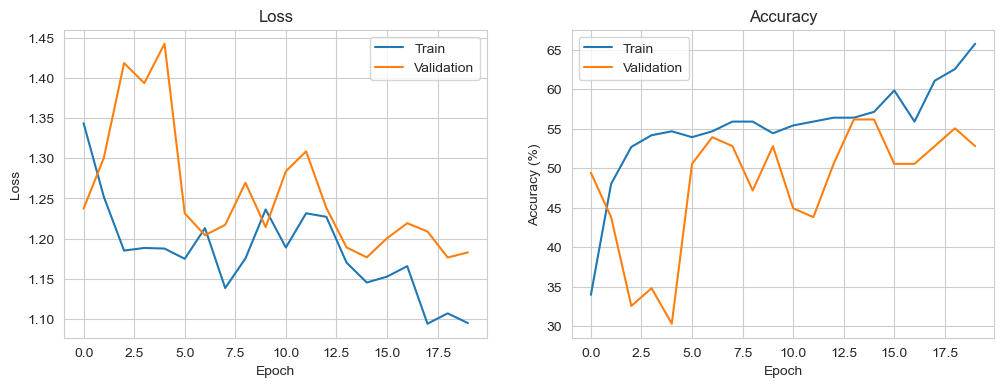

In [9]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss
ax1.plot(train_losses, label='Train')
ax1.plot(val_losses, label='Validation')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy
ax2.plot(train_accuracies, label='Train')
ax2.plot(val_accuracies, label='Validation')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

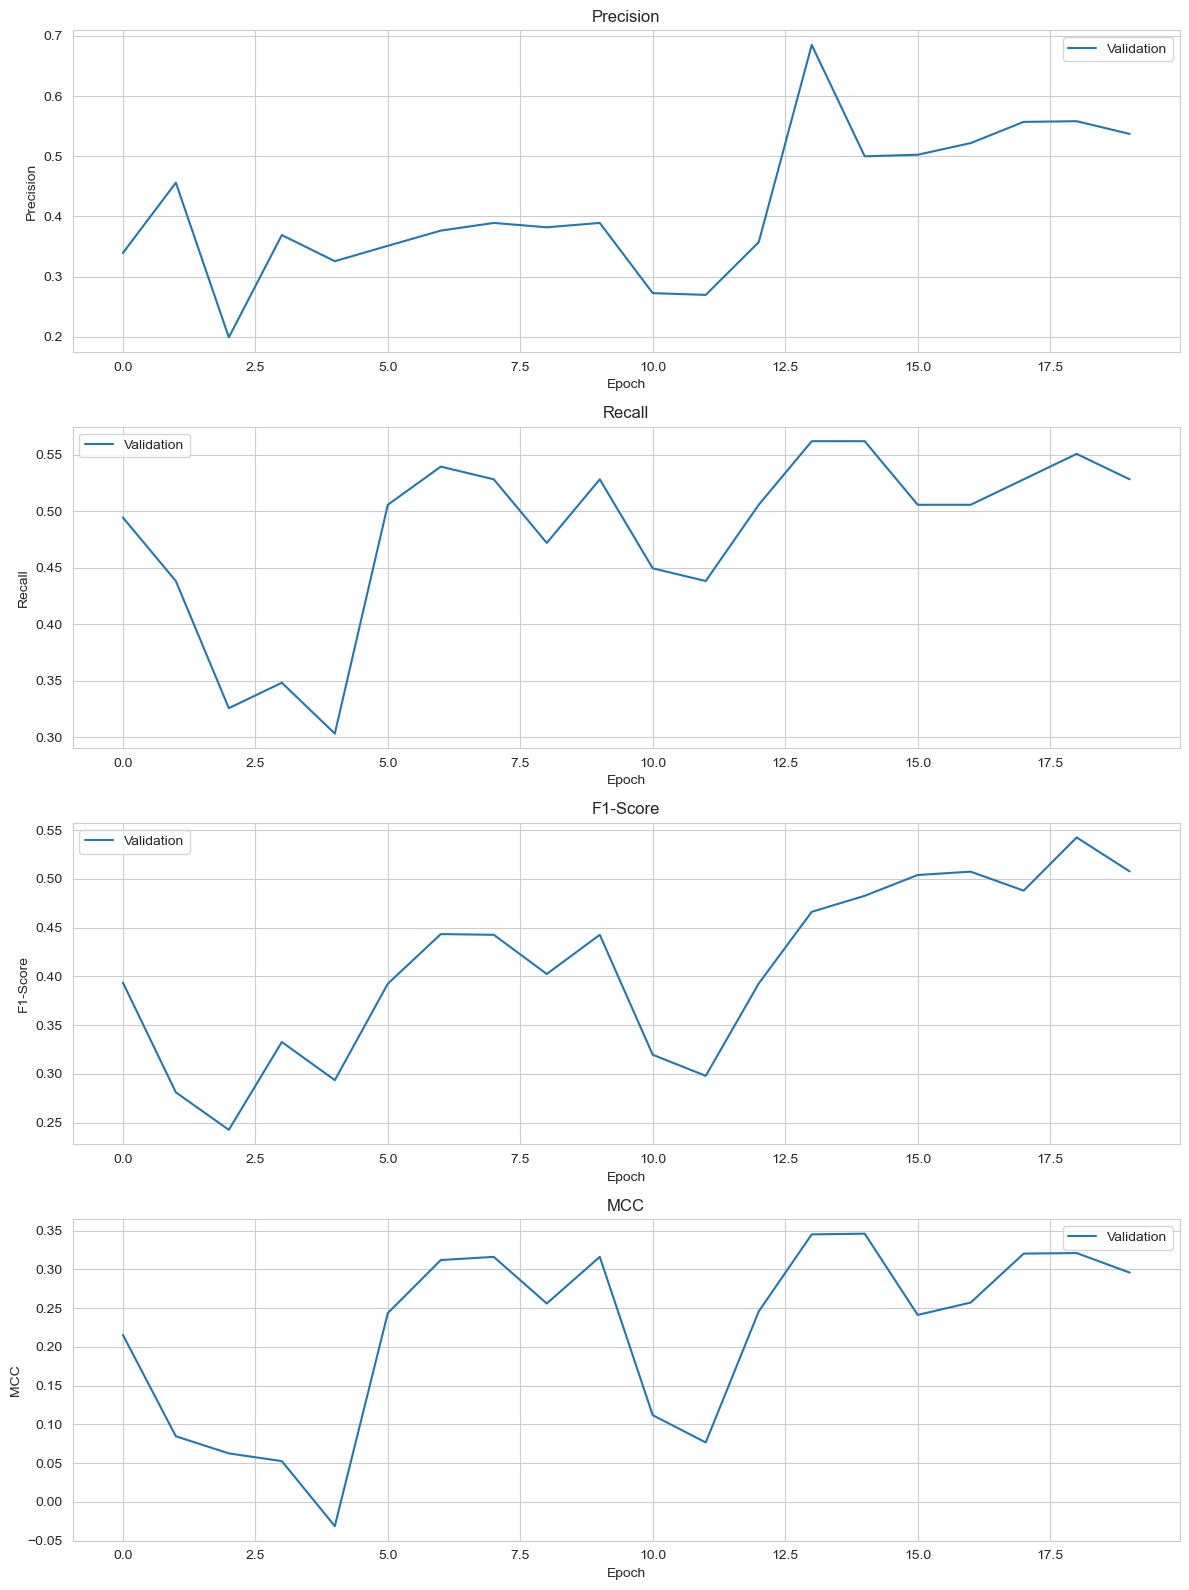

In [10]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

# Precision
ax1.plot(val_precisions, label='Validation')
ax1.set_title('Precision')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Precision')
ax1.legend()

# Recall
ax2.plot(val_recalls, label='Validation')
ax2.set_title('Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall')
ax2.legend()

# F1-score
ax3.plot(val_f1_scores, label='Validation')
ax3.set_title('F1-Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-Score')
ax3.legend()

# MCC
ax4.plot(val_mccs, label='Validation')
ax4.set_title('MCC')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('MCC')
ax4.legend()

plt.tight_layout()
plt.show()


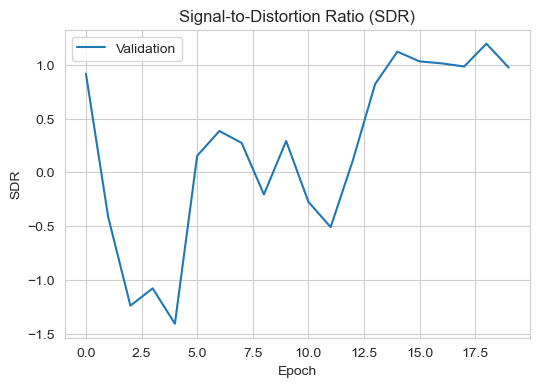

In [11]:
# Convert list of tensors to list of numpy arrays (if necessary)
if isinstance(val_sdrs[0], torch.Tensor):
    val_sdrs_np = [sdr.cpu().numpy() for sdr in val_sdrs]
else:
    val_sdrs_np = val_sdrs

# Plotting SDR
fig, ax = plt.subplots(figsize=(6, 4))

# SDR
ax.plot(val_sdrs_np, label='Validation')
ax.set_title('Signal-to-Distortion Ratio (SDR)')
ax.set_xlabel('Epoch')
ax.set_ylabel('SDR')
ax.legend()

plt.show()


/Users/zainhazzouri/mambaforge/envs/Bachelor_Thesis/lib/python3.10/site-packages/torchaudio/functional/functional.py:578: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


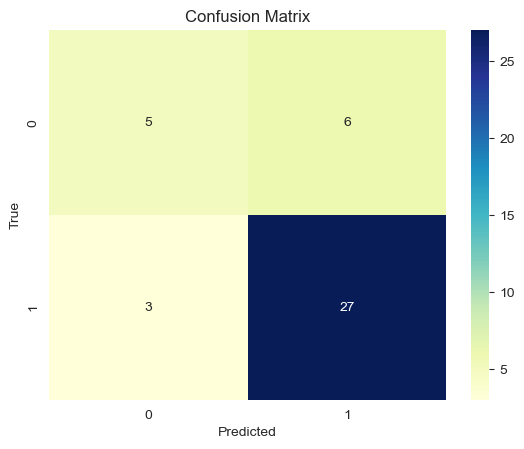

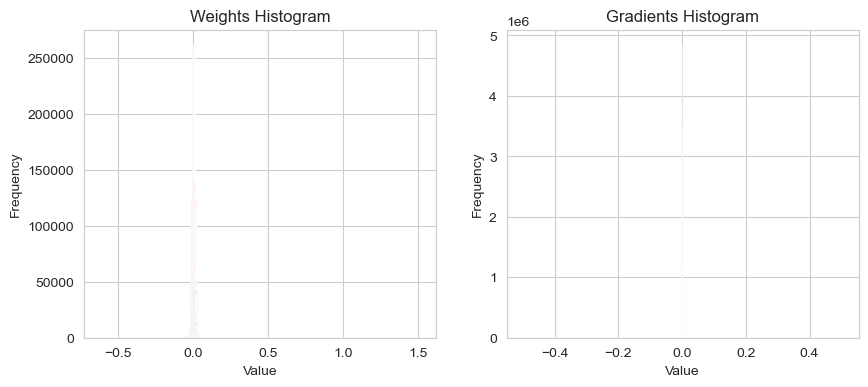

In [12]:
def plot_confusion_matrix(y_true, y_pred, labels, ax=None, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if ax is None:
        _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)

def get_weights_gradients(model):
    weights = []
    gradients = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights.append(param.data.cpu().numpy())
            gradients.append(param.grad.data.cpu().numpy())
    return weights, gradients

def plot_histograms(weights, gradients, figsize=(10, 4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    for w in weights:
        ax1.hist(w.flatten(), bins=100, alpha=0.5)
    ax1.set_title("Weights Histogram")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Frequency")

    for g in gradients:
        ax2.hist(g.flatten(), bins=100, alpha=0.5)
    ax2.set_title("Gradients Histogram")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Frequency")

    plt.show()

# Get true labels and predictions on the validation set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title="Confusion Matrix")

# Extract weights and gradients and plot histograms
weights, gradients = get_weights_gradients(model)
plot_histograms(weights, gradients)


In [13]:
# Save the trained model
torch.save(model.state_dict(), "CNNModel_speech_music_discrimination.pth")
print("Model saved.")

Model saved.


In [14]:
# # this part doesn't work any more because of the change in the model -> "attention" layer
# # Show model summary
# try:
#     from torchsummary import summary
#     print("\nModel summary:")
#
#     original_device = device
#     if device == 'mps': # because MPS is not supported by torchsummary
#         device = 'cpu'
#
#
#     class ModelWrapper(nn.Module):
#         def __init__(self, module):
#             super(ModelWrapper, self).__init__()
#             self.module = module
#
#         def forward(self, x):
#             return self.module(x)
#
#     model = ModelWrapper(CNNModel(mfcc_dim=32, output_ch=4)).to(device)
#     summary(model, input_size=(1, 32, 112))
#
#     if original_device == 'mps': # Restore original device
#         device = original_device
#         model.to(device)
#
# except ImportError:
#     print("\nPlease install torchsummary to display the model summary. Use `pip install torchsummary`.")